In [1]:
import math
import json
#import cv
import gc
import numpy as np
import numpy.ma as ma
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.engine import Layer

from keras.layers import Input, Dense, Convolution3D, MaxPooling3D, Reshape, Flatten, BatchNormalization, Lambda, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model, Sequential, model_from_json
from keras.utils import multi_gpu_model
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from keras.models import load_model


In [2]:
#import vis.utils as utils
#from vis.visualization import visualize_saliency
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as pre
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import tensorflow as tf
import numpy as np
import os, random, gc, pickle
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
import build_multiBranch as bm


In [3]:
#import data_processing as process
#import build_multiBranch as bm
#import Fit_model as fitter
#import Evaluate_model as Evalu
#import generate_patches3D as generator

In [4]:

metadata = pd.read_csv('ADNI1_Screening_1.5T.csv')
total_data = (metadata.Group !=0).values.astype('bool')

dirName = '/home/dipnilc/Dipnil/ADNI_imaging'

#listOFFiles = process.getListOfFiles(dirName)
#for elem in listOFFiles:
    #print(elem)

#print("***************")

listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(dirName):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]


In [5]:
metadata

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,63897,941_S_1363,MCI,F,70,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/12/2007,NiFTI,1/18/2019
1,97327,941_S_1311,MCI,M,69,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,1/18/2019
2,63888,941_S_1295,MCI,M,77,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,1/18/2019
3,63879,941_S_1203,CN,M,83,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,1/18/2019
4,63874,941_S_1202,CN,M,78,1,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,1/18/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
1068,40674,002_S_0559,CN,M,79,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/23/2006,NiFTI,1/18/2019
1069,45117,002_S_0413,CN,F,76,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/02/2006,NiFTI,1/18/2019
1070,118673,002_S_0413,CN,F,76,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,1/18/2019
1071,45108,002_S_0295,CN,M,85,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,1/18/2019


In [6]:
# make sure each subject appear at most once in the training data and so does in the test data.
subjects_count = 0
subjects_dict = []

In [7]:
for elem in listOfFiles:
    #im = 'ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070216232854688_S14782_I40657.nii'
    #img = nib.load(elem).get_data()
    #img = np.asarray(img)
    split_names = elem.split('/')
    subject_name = split_names[6]
    if subjects_count==0:
        subjects_count +=1
        subjects_dict.append(subject_name)
    else:
        if subject_name in subjects_dict:
            subjects_count += 0
            #subjects_dict.append(subject_name)
	    #continue
        else:
            subjects_count += 1
            subjects_dict.append(subject_name)
    if subjects_count>1072:
         break
np.shape(subjects_dict)


(817,)

In [8]:
subjects_dict1=subjects_dict

In [9]:
np.shape(subjects_dict1)


(817,)

In [10]:
data = np.zeros((int(subjects_count), 155, 155, 95))
#data = np.zeros((int(subjects_count), 256, 256, 166))
labels = np.zeros((int(subjects_count), 1))
labels_C = np.zeros((int(subjects_count), 1))
#scaler = MinMaxScaler()

In [11]:
idx=pd.DataFrame(np.arange(0,1073))
idx.columns=['Index']
idx

,Index
0,0
1,1
2,2
3,3
4,4
...,...
1068,1068
1069,1069
1070,1070
1071,1071


In [12]:
metadata1=pd.concat([idx,metadata],axis=1)
metadata1[total_data]

,Index,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,0,63897,941_S_1363,MCI,F,70,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/12/2007,NiFTI,1/18/2019
1,1,97327,941_S_1311,MCI,M,69,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,1/18/2019
2,2,63888,941_S_1295,MCI,M,77,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/09/2007,NiFTI,1/18/2019
3,3,63879,941_S_1203,CN,M,83,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,1/18/2019
4,4,63874,941_S_1202,CN,M,78,1,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,NiFTI,1/18/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,1068,40674,002_S_0559,CN,M,79,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/23/2006,NiFTI,1/18/2019
1069,1069,45117,002_S_0413,CN,F,76,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/02/2006,NiFTI,1/18/2019
1070,1070,118673,002_S_0413,CN,F,76,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/02/2006,NiFTI,1/18/2019
1071,1071,45108,002_S_0295,CN,M,85,1,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,1/18/2019


In [13]:
'''img = nib.load(elem).get_fdata()
img = np.asarray(img)
img = img[35:190, 35:190, 40:135]        
scaler1 = MinMaxScaler()
for jj in range(95):
    img[:, :, jj] = scaler1.fit_transform(img[:, :, jj])
    scaler2 = MinMaxScaler()
for tt in range(155):
    img[tt, :, :] = scaler2.fit_transform(img[tt, :, :])
    scaler3 = MinMaxScaler()
for kk in range(155):
    img[:, kk, :] = scaler3.fit_transform(img[:, kk, :])
#print(img)
np.shape(img)'''

'img = nib.load(elem).get_fdata()\nimg = np.asarray(img)\nimg = img[35:190, 35:190, 40:135]        \nscaler1 = MinMaxScaler()\nfor jj in range(95):\n    img[:, :, jj] = scaler1.fit_transform(img[:, :, jj])\n    scaler2 = MinMaxScaler()\nfor tt in range(155):\n    img[tt, :, :] = scaler2.fit_transform(img[tt, :, :])\n    scaler3 = MinMaxScaler()\nfor kk in range(155):\n    img[:, kk, :] = scaler3.fit_transform(img[:, kk, :])\n#print(img)\nnp.shape(img)'

In [14]:
img = nib.load(elem).get_fdata()
np.shape(img)
#(256, 256, 166)

(256, 256, 166)

In [15]:
ind_img = 0
for elem in listOfFiles:

    split_names = elem.split('/')
    subject_name = split_names[6]
    if subject_name in subjects_dict:
        img = nib.load(elem).get_fdata()
        #img = np.asarray(img)
        img = img[35:190, 35:190, 40:135]
        #img = img[0:256, 0:256, 0:166]
        scaler1 = MinMaxScaler()
        for jj in range(95):
            img[:, :, jj] = scaler1.fit_transform(img[:, :, jj])
        scaler2 = MinMaxScaler()
        for tt in range(155):
            img[tt, :, :] = scaler2.fit_transform(img[tt, :, :])
        scaler3 = MinMaxScaler()
        for kk in range(155):
            img[:, kk, :] = scaler3.fit_transform(img[:, kk, :])

        data[ind_img, :, :, :] = img
        indexM=metadata1.loc[metadata1['Subject']==(subject_name)]
    #indexM = int(indexM[0])
        group=metadata1.Group[metadata1['Subject']==(subject_name)] 
        #print(group[0])
        group=pd.DataFrame(group)       
        group = group.iloc[0]['Group']
        if group=='AD':
            label = 2
            label_c = 0
        if group=='CN':
            label = 0
            label_c = 1
        if group=='MCI':
            label = 1
            label_c = 0
        labels[ind_img] = label
        labels_C[ind_img] = label_c
        ind_img += 1
        sub_ind = subjects_dict.index(subject_name)
        subjects_dict.pop(sub_ind)


In [16]:
listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(dirName):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]

#make sure each subject appear at most once in the training data and so does in the test data.
subjects_count = 0
subjects_dict = []
for elem in listOfFiles:
    #im = 'ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070216232854688_S14782_I40657.nii'
    #img = nib.load(elem).get_data()
    #img = np.asarray(img)
    split_names = elem.split('/')
    subject_name = split_names[6]
    if subjects_count==0:
        subjects_count +=1
        subjects_dict.append(subject_name)
    else:
        if subject_name in subjects_dict:
            subjects_count += 0
            #subjects_dict.append(subject_name)
	    #continue
        else:
            subjects_count += 1
            subjects_dict.append(subject_name)
    if subjects_count>999:
         break


In [17]:
np.shape(subjects_dict)

(817,)

In [18]:
#data = scaler.fit(data)
data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2], data.shape[3], 1))
print(data.shape)


(817, 155, 155, 95, 1)


In [19]:
X_train, X_test, Y_train, Y_test, id_train,id_test = train_test_split(data, labels,subjects_dict, test_size=0.1, train_size=0.9, random_state=7)
#X_train, X_test, Y_train_C, Y_test_C = train_test_split(data, labels_C, test_size=0.1, train_size=0.9, random_state=7)
np.save("Labels2_tr", Y_train)
np.save("Labels2_ts", Y_test)
#np.save("Labels2_C_tr", Y_train_C)
#np.save("Labels2_C_ts", Y_test_C)
Y_train = np_utils.to_categorical(Y_train, 3)
Y_test = np_utils.to_categorical(Y_test, 3)
#Y_train_C = np_utils.to_categorical(Y_train_C, 2)
#Y_test_C = np_utils.to_categorical(Y_test_C, 2)
np.save("wholeImg_tr", X_train)
np.save("wholeImg_ts", X_test)
num_tr = X_train.shape[0]
num_ts = X_test.shape[0]
print("Saved the data")

Saved the data


In [21]:
num_branches = 27
batch_size = 4
nb_epochs = 10
early_stopping_patience = 20

In [22]:
channels = 155
img_size_x = 155
img_size_y = 95
batch_size = 4
nb_classes = 3
nb_epochs = 25
learning_rate = 0.003
early_stopping_patience = 20
class_names = ["AD","CN", "MCI"]

In [22]:
ids=pd.concat([pd.DataFrame(id_train),pd.DataFrame(id_test)],axis=0)
pd.DataFrame(ids).to_csv("/home/dipnilc/Dipnil/Codes/features_ID1.csv", header=None, sep=',',index=None)

In [23]:
branch_input = Input(shape= (155,155,95,1))
model_temp = bm.build_separate_model(branch_input)
val_data = X_test
val_labels = Y_test
#val_labels_C = Y_test_C
#model_temp = multi_gpu_model(model_temp, gpus=2)
opt = keras.optimizers.Adam(lr=2e-4)
model_temp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

v = 22071
model_weights_file = 'img_classifierW_weights_%s.h5' %v
epoch_weights_file = 'img_classifierW_weights_%s_{epoch:02d}.hdf5' %v
model_file = 'img_classifierW_model%s.h5' %v
history_file = 'img_classifierW_history_%s.json' %v


checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
callbacks_list = [checkpoint, early_stopping]
#datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False,samplewise_std_normalization=False,zca_whitening=False,rotation_range=15,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=False,vertical_flip=False)

model_temp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 155, 155, 95, 1)] 0         
_________________________________________________________________
conv1 (Conv3D)               (None, 151, 151, 91, 32)  4032      
_________________________________________________________________
act1 (Activation)            (None, 151, 151, 91, 32)  0         
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 75, 75, 45, 32)    0         
_________________________________________________________________
class_conv (Conv3D)          (None, 75, 75, 45, 3)     99        
_________________________________________________________________
class_score (Activation)     (None, 75, 75, 45, 3)     0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 759375)            0     

In [30]:
m = model_temp.fit(X_train, Y_train,batch_size=batch_size,epochs=100,
 verbose=1, shuffle=True, validation_data=(val_data, val_labels))


Epoch 1/100
184/184 [==============================] - 466s 3s/step - loss: 1.4250 - auc: 0.4965 - accuracy: 0.3306 - val_loss: 1.0548 - val_auc: 0.6170 - val_accuracy: 0.4634
Epoch 2/100
184/184 [==============================] - 462s 3s/step - loss: 1.3575 - auc: 0.5178 - accuracy: 0.3388 - val_loss: 1.6031 - val_auc: 0.3427 - val_accuracy: 0.1829
Epoch 3/100
184/184 [==============================] - 461s 3s/step - loss: 1.2151 - auc: 0.5235 - accuracy: 0.3578 - val_loss: 1.6036 - val_auc: 0.5718 - val_accuracy: 0.3537
Epoch 4/100
 66/184 [=========>....................] - ETA: 4:47 - loss: 1.1005 - auc: 0.5806 - accuracy: 0.4015

KeyboardInterrupt: 

In [ ]:
def save_model_and_weights(model):
        model.save(model_file)
        model.save_weights(model_weights_file)

def save_model_history(m):
    with open(history_file, 'wb') as history_json_file:
        json.dump(m.history, history_json_file)

    return 'Saved model history to disk'
print(save_model_and_weights(model_temp))
#print(save_model_history(m))
#del model_temp
#del m
gc.collect()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_temp, to_file='new_model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
model_temp.load_weights("img_classifierW_weights_7.h5")


In [26]:
neuron_model=Model(inputs=branch_input,outputs=model_temp.layers[-4].output)

In [27]:
features = neuron_model.predict(X_train)

In [28]:
features_test=neuron_model.predict(X_test)

In [29]:
print(features.shape)
print(features_test.shape)

(735, 100)
(82, 100)


In [36]:
feature_extrc=np.concatenate((features,features_test))
feature_extrc.shape

(817, 100)

In [38]:
feature_extrc=pd.concat([pd.DataFrame(feature_extrc),pd.DataFrame(labels)],axis=1)

In [32]:
pd.DataFrame(feature_extrc).to_csv("/home/dipnilc/Dipnil/features_WI.csv", header=None, sep=',',index=None)

In [39]:
df_ADNI = feature_extrc
#df_ADNI['label'] = labels
df_ADNI.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,0
0,0.190868,0.612823,0.122510,0.479436,0.552340,0.546955,0.739786,0.256518,0.768288,0.338841,...,0.728418,0.276502,0.645686,0.420437,0.532468,0.612037,0.562422,0.401546,0.686796,1.0
1,0.542959,0.241422,0.318357,0.858277,0.446090,0.640758,0.656976,0.145703,0.277533,0.843599,...,0.200939,0.508760,0.928591,0.128735,0.754474,0.546570,0.886401,0.080079,0.351513,0.0
2,0.666970,0.524511,0.452475,0.251057,0.195288,0.613900,0.491292,0.573853,0.336942,0.221391,...,0.345140,0.845208,0.743177,0.630527,0.140001,0.319016,0.367851,0.351573,0.541087,1.0
3,0.721956,0.094321,0.808982,0.624550,0.243795,0.315373,0.602860,0.104398,0.085047,0.667077,...,0.296118,0.701154,0.864388,0.134315,0.888835,0.263937,0.898586,0.086185,0.215592,0.0
4,0.164838,0.104838,0.650132,0.906741,0.368107,0.088687,0.863435,0.065884,0.199882,0.821567,...,0.295671,0.726689,0.898934,0.059258,0.619995,0.382779,0.867531,0.215383,0.212846,0.0


In [45]:
from sklearn.decomposition import PCA
pca_ADNI = PCA(n_components=10)
#principalComponents_ADNI = pca_ADNI.fit_transform(df_ADNI[feat_cols].values)
principalComponents_ADNI = pca_ADNI.fit_transform(df_ADNI.iloc[:,:-1])

In [48]:
np.shape(principalComponents_ADNI)
pd.DataFrame(principalComponents_ADNI).to_csv("/home/dipnilc/Dipnil/features_WI_PCA.csv", header=None, sep=',',index=None)

In [41]:
print('Explained variation per principal component: {}'.format(pca_ADNI.explained_variance_ratio_))
variance = pca_ADNI.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca_ADNI.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

Explained variation per principal component: [0.303005   0.24762982]


array([30.300001, 55.1     ], dtype=float32)

NameError: name 'var' is not defined

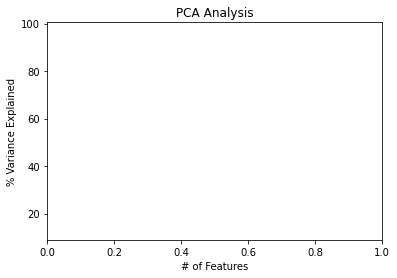

In [1]:
import matplotlib.pyplot as plt
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(9,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

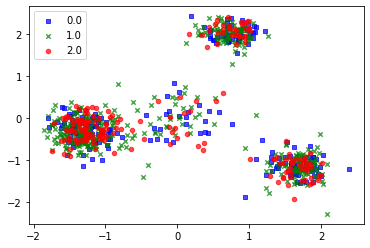

In [44]:
principal_ADNI_Df = pd.DataFrame(data = principalComponents_ADNI
             , columns = ['principal component 1', 'principal component 2'])
principal_ADNI_Df['y'] = labels
import matplotlib.pyplot as plt
from mlxtend.plotting import category_scatter
fig = category_scatter(x='principal component 1', y='principal component 2', label_col='y', 
                       data=principal_ADNI_Df, legend_loc='upper left')


In [ ]:
"""from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
transfer_model=Sequential()
transfer_model.add(VGG16(include_top=False,weights='imagenet',pooling='avg'))
transfer_model.add(Dense(3,activation='softmax'))
transfer_model.layers[0].trainable=False
transfer_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])
transfer_model.summary()"""